In [21]:
import pandas as pd

df = pd.read_csv("DATATHON 2025\combined_dataset_labels.csv")
df

,image_file,main_category,sub_category,dataset
0,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Public Cleanliness & Public Property Damage,Vandalism,graffitti_labels
1,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Public Cleanliness & Public Property Damage,Vandalism,graffitti_labels
2,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Public Cleanliness & Public Property Damage,Vandalism,graffitti_labels
3,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Public Cleanliness & Public Property Damage,Vandalism,graffitti_labels
4,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Public Cleanliness & Public Property Damage,Vandalism,graffitti_labels
...,...,...,...,...
6684,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Road & Infrastructure Issues,Broken/Missing Road Signs,damagedsigns_labeled_data
6685,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Road & Infrastructure Issues,Broken/Missing Road Signs,damagedsigns_labeled_data
6686,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Public Cleanliness & Public Property Damage,Vandalism,damagedsigns_labeled_data
6687,C:\Users\lchat\One Drive-UoM\OneDrive - Univer...,Road & Infrastructure Issues,Broken/Missing Road Signs,damagedsigns_labeled_data


In [22]:
# Inspect dataframe structure and unique main categories
print(df.info(memory_usage='deep'))
print('\nUnique main categories:')
print(df['main_category'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6689 entries, 0 to 6688
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_file     6689 non-null   object
 1   main_category  6689 non-null   object
 2   sub_category   6689 non-null   object
 3   dataset        6689 non-null   object
dtypes: object(4)
memory usage: 2.7 MB
None

Unique main categories:
['Public Cleanliness & Public Property Damage'
 'Road & Infrastructure Issues']


In [ ]:
# Install TensorFlow (run once; remove or comment out after environment is set up)
%pip install -q tensorflow


Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


# --- 1b. Normalize image paths & check existence ---
import os, math

# If image_file column currently stores relative paths like "DATATHON 2025\\Graffitti\\train\\file.jpg"
base_dir = r"C:\Users\lchat\One Drive-UoM\OneDrive - University of Moratuwa\Datathon-2025-"

def to_abs(p):
    p = str(p).strip().replace('/', os.sep)
    if os.path.isabs(p):
        return p
    return os.path.join(base_dir, p)

df["abs_image_path"] = df["image_file"].apply(to_abs)

missing_files = [p for p in df["abs_image_path"] if not os.path.exists(p)]
print(f"Total images: {len(df)}, Missing: {len(missing_files)}")
if missing_files:
    print("Sample missing:", missing_files[:5])

# Optionally drop rows with missing images
df = df[~df["abs_image_path"].isin(missing_files)].reset_index(drop=True)
print("After dropping missing:", len(df))

# Define main categories (unique list)
main_categories = sorted(df["main_category"].str.split(';').explode().unique())
num_classes = len(main_categories)

# Map categories to indices
cat_to_idx = {cat: i for i, cat in enumerate(main_categories)}

# Function to multi-hot encode the labels
def encode_labels(label_str):
    labels = label_str.split(';')
    encoding = np.zeros(num_classes)
    for lbl in labels:
        encoding[cat_to_idx[lbl]] = 1
    return encoding

df["encoded_labels"] = df["main_category"].apply(encode_labels)

# ------------------------
# 2. Train/Validation split
# ------------------------
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# ------------------------
# 3. Data Generators
# ------------------------
# ...existing code...
img_size = (224, 224)
batch_size = 32

import itertools

def generator(df_part, shuffle=True):
    idxs = np.arange(len(df_part))
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for start in range(0, len(idxs), batch_size):
            batch_ids = idxs[start:start+batch_size]
            images, labels = [], []
            for i in batch_ids:
                row = df_part.iloc[i]
                path = row["abs_image_path"]
                try:
                    img = tf.keras.utils.load_img(path, target_size=img_size)
                    img = tf.keras.utils.img_to_array(img) / 255.0
                except (FileNotFoundError, OSError) as e:
                    # Skip missing/corrupt file
                    continue
                images.append(img)
                labels.append(row["encoded_labels"])
            if images:  # only yield if not empty
                yield np.array(images), np.array(labels)

train_gen = generator(train_df)
val_gen = generator(val_df, shuffle=False)

import math
steps_per_epoch = math.ceil(len(train_df) / batch_size)
val_steps = math.ceil(len(val_df) / batch_size)
# ...existing code...
# ------------------------
# 4. CNN Model
# ------------------------
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')  # sigmoid for multi-label
])

# ...existing code...
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='bin_acc'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    #tf.keras.callbacks.ModelCheckpoint("main_category_classifier_best.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=20,
    callbacks=callbacks
)

model.save("main_category_classifier_final.h5")
# ...existing code...

Total images: 6689, Missing: 1
Sample missing: ['C:\\Users\\lchat\\One Drive-UoM\\OneDrive - University of Moratuwa\\Datathon-2025-\\DATATHON 2025\\Graffitti\\train\\6630f1af7a4e0-aksi-vandalisme-dengan-berbagai-coretan-hiasi-sejumlah-pertokoan-di-kawasan-jalan-malioboro-yogyakarta_1265_711_jpg.rf.9a702c23ebebc9e19b86f70c8e960163.jpg']
After dropping missing: 6688


C:\Users\lchat\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 150s 884ms/step - auc: 0.7436 - bin_acc: 0.6877 - loss: 0.6157 - precision: 0.6897 - recall: 0.6785 - val_auc: 0.9121 - val_bin_acc: 0.8128 - val_loss: 0.3722 - val_precision: 0.8102 - val_recall: 0.8169
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 104s 620ms/step - auc: 0.9199 - bin_acc: 0.8271 - loss: 0.3518 - precision: 0.8232 - recall: 0.8330 - val_auc: 0.9486 - val_bin_acc: 0.8793 - val_loss: 0.2942 - val_precision: 0.8686 - val_recall: 0.8939
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 103s 616ms/step - auc: 0.9476 - bin_acc: 0.8660 - loss: 0.2871 - precision: 0.8650 - recall: 0.8671 - val_auc: 0.9530 - val_bin_acc: 0.8834 - val_loss: 0.2966 - val_precision: 0.8817 - val_recall: 0.8857
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 103s 615ms/step - auc: 0.9618 - bin_acc: 0.8862 - loss: 0.2470 - precision: 0.8908 - recall: 0.8803 - val_auc: 0.9727 - val_bin_acc: 0.9096 - val_loss: 0.2254 - val_precision: 0.9083 - val_recall: 0.9111
Epoch 5/20
168/168 ━━━━━

In [24]:
# --- 5. Manual single-image classification (local file) ---

import os, glob, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image
from IPython.display import display

# Assumes base_dir, main_categories already defined earlier.
# Load model if not in memory
if 'model' not in globals():
    model = tf.keras.models.load_model("main_category_classifier_final.h5")

IMG_SIZE = (224, 224)
THRESHOLD = 0.5  # adjust if needed (lower -> more labels)

def preprocess_pil(pil_img):
    pil_img = pil_img.convert("RGB").resize(IMG_SIZE)
    arr = image.img_to_array(pil_img) / 255.0
    return np.expand_dims(arr, axis=0)

def predict_batch(img_batch):
    probs = model.predict(img_batch, verbose=0)[0]
    selected = [(cat, float(p)) for cat, p in zip(main_categories, probs) if p >= THRESHOLD]
    if not selected:  # fallback top 3
        top_idx = np.argsort(probs)[-3:][::-1]
        selected = [(main_categories[i], float(probs[i])) for i in top_idx]
    selected.sort(key=lambda x: x[1], reverse=True)
    return probs, selected

def classify_local(image_name):
    path = os.path.join(base_dir, image_name)
    if not os.path.exists(path):
        print("File not found:", path)
        return None
    pil_img = Image.open(path)
    display(pil_img)
    batch = preprocess_pil(pil_img)
    probs, selected = predict_batch(batch)
    print(f"\nPredictions (threshold={THRESHOLD}):")
    for cat, p in selected:
        print(f"  {cat}: {p:.4f}")
    return probs

print("Available images in notebook folder:")
for f in sorted(glob.glob(os.path.join(base_dir, "*.*"))):
    if f.lower().endswith((".jpg", ".jpeg", ".png")):
        print(" -", os.path.basename(f))

# Run classification on the target image
image_name = "test_graffitti.jpeg"


Available images in notebook folder:
 - test_graffitti.jpeg
 - test_roadsign.jpeg


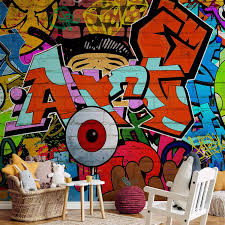


Predictions (threshold=0.5):
  Public Cleanliness & Public Property Damage: 0.9727


array([0.97270614, 0.02282909], dtype=float32)

In [ ]:
image_name = "test_graffitti.jpeg"
classify_local(image_name)

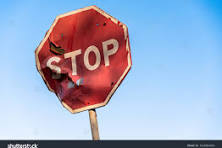


Predictions (threshold=0.5):
  Road & Infrastructure Issues: 0.8770


array([0.16201374, 0.8770042 ], dtype=float32)

In [20]:
image_name = "test_roadsign.jpeg"
classify_local(image_name)

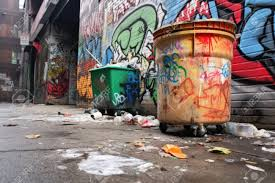


Predictions (threshold=0.5):
  Public Cleanliness & Public Property Damage: 0.9317


array([0.9316583 , 0.06405998], dtype=float32)

In [25]:
image_name = "test_trash.jpeg"
classify_local(image_name)

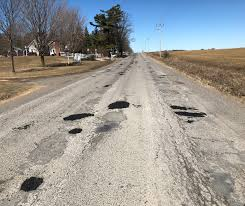


Predictions (threshold=0.5):
  Public Cleanliness & Public Property Damage: 0.5594


array([0.55936694, 0.43262303], dtype=float32)

In [28]:
image_name = "pothole_3.jpeg"
classify_local(image_name)

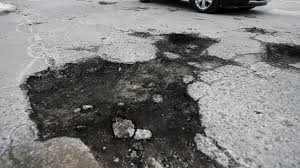


Predictions (threshold=0.5):
  Road & Infrastructure Issues: 0.9419


array([0.0644553 , 0.94188213], dtype=float32)

In [27]:
image_name = "test_pothole2.jpeg"
classify_local(image_name)